# Introduction 
The experminet below tries to extend the idea that we hav eprocured in exp1. Instead of checking the error rate for normal bandlimited signals we will work with markov chains.

- We will start with markov chains backed up by some generator matrix.
- They will generate paths of "high resolution" from which we will sample ant try to reconstruct the entirety of the chain. Let say that we will do a decimation rate of 1-4 samples.
- Once we have those samples we passe them to a neural network which will likely have a BCE loss and will try to predict 0 or 1 in a specifc spot;
- Our hope is that we will see some point where there will be a *stark* drop in performance, probably due to an analogous phenomenon to sampling at subnyquist rate.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd
from sp_sims.simulators.stochasticprocesses import RaceOfExponentials,TransitionMatrixBD

plt.style.use('rose-pine-dawn')
%load_ext autoreload
%autoreload 2

# Setup

## Constant Declarations

In [2]:
sampling_rate = 1
high_res_delta = 0.001 # For generating the dataset and later sample
decimanation_factor = 4 # For every 4 samples we take 1 sample
path_length = 64
baseline_rates = {"lam": 1/10,"mu":4/10}
baseline_dataset_size = 2048
initial_state = 0

## Create Datasets

In [3]:
# Generate Basline dataset (the one we learn on )
def generate_state_tape(dataset_size: int, rates: dict, path_length: int, init_state: int = 0):
    sts = []
    for i in range(dataset_size):
        Q = np.array([[-rates["lam"],rates["lam"]],[rates["mu"],-rates["mu"]]])# Necessary to fit into TransitionMatrixBD generator
        # This generator will generate at the same interval so there is no need to have 
        generator = TransitionMatrixBD(Q, sampling_interval = 1)
        state_tape = generator.generate_history(init_state, path_length)
        sts.append(state_tape)
    return sts
state_tape = generate_state_tape(baseline_dataset_size,baseline_rates,path_length)

In [4]:
# Sample the dataset
sampled_sts = []
for i in range(len(state_tape)):
    sampled_sts.append(state_tape[i][::decimanation_factor])


## Create Networks


In [23]:
from samprecon.reconstructors.markov_reconstructors import BCEReconstructor
import torch
# import binary cross entorpy loss
import torch.nn as nn
from samprecon.reconstructors.markov_reconstructors import BCEReconstructor
from torch.optim import Adam
from tqdm.notebook import tqdm

In [24]:
num_epochs = 10
batch_size = 16
bce_network = BCEReconstructor(path_length//decimanation_factor, path_length)
optimizer = Adam(bce_network.parameters(), lr=0.001)

criterion = nn.BCEWithLogitsLoss()

## Train Network

In [25]:
# Training
num_batches = len(sampled_sts)//batch_size
print(f'Executing the training with {num_batches} batches')
for epoch in tqdm(range(num_epochs),desc="Epochs",leave=False):
    batch_tqdm = tqdm(range(num_batches), desc="Batch",leave=True)
    for i in range(num_batches):
        batch_sts = torch.Tensor(sampled_sts[i*batch_size:(i+1)*batch_size]).to(torch.float).view(batch_size,-1)# Careful with len(sampled_sts)%batch_size != 0
        y_batch = torch.Tensor(state_tape[i*batch_size:(i+1)*batch_size]).to(torch.float).view(batch_size,-1)
        upsampled = bce_network(batch_sts)

        # Compute Loss
        loss = criterion(upsampled,y_batch)
        # Set batch_tqdm description
        batch_tqdm.set_description(f"Loss is {loss.item()}")
        batch_tqdm.update(1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Executing the training with 1274 batches


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/1274 [00:00<?, ?it/s]

Batch:   0%|          | 0/1274 [00:00<?, ?it/s]

Batch:   0%|          | 0/1274 [00:00<?, ?it/s]

Batch:   0%|          | 0/1274 [00:00<?, ?it/s]

Batch:   0%|          | 0/1274 [00:00<?, ?it/s]

Batch:   0%|          | 0/1274 [00:00<?, ?it/s]

Batch:   0%|          | 0/1274 [00:00<?, ?it/s]

Batch:   0%|          | 0/1274 [00:00<?, ?it/s]

Batch:   0%|          | 0/1274 [00:00<?, ?it/s]

Batch:   0%|          | 0/1274 [00:00<?, ?it/s]

In [48]:
# Generate one more batch
batch = torch.Tensor(generate_state_tape(batch_size, baseline_rates, path_length)).to(torch.float).view(1,-1,64)
batch_sampled = batch[:,:,::decimanation_factor]
print(f"Batch shape is {batch.shape}")
bce_network.eval()
res = bce_network(batch_sampled)
loss = criterion(res,batch).detach().item()
siggy = nn.Sigmoid()

batch = batch.detach().numpy().squeeze()
batch_sampled = batch_sampled.detach().numpy().squeeze()
res = siggy(res).detach().numpy().squeeze()
# Hard set 0 or 1 instead of sigmoid. Threshold is 0.5

print(f"Average loss is {loss}")

Batch shape is torch.Size([1, 16, 64])
Average loss is 0.2758176028728485


Shape of the three is (64,), (16,), (64,)
Shape of the three is (64,), (16,), (64,)
Shape of the three is (64,), (16,), (64,)


[]

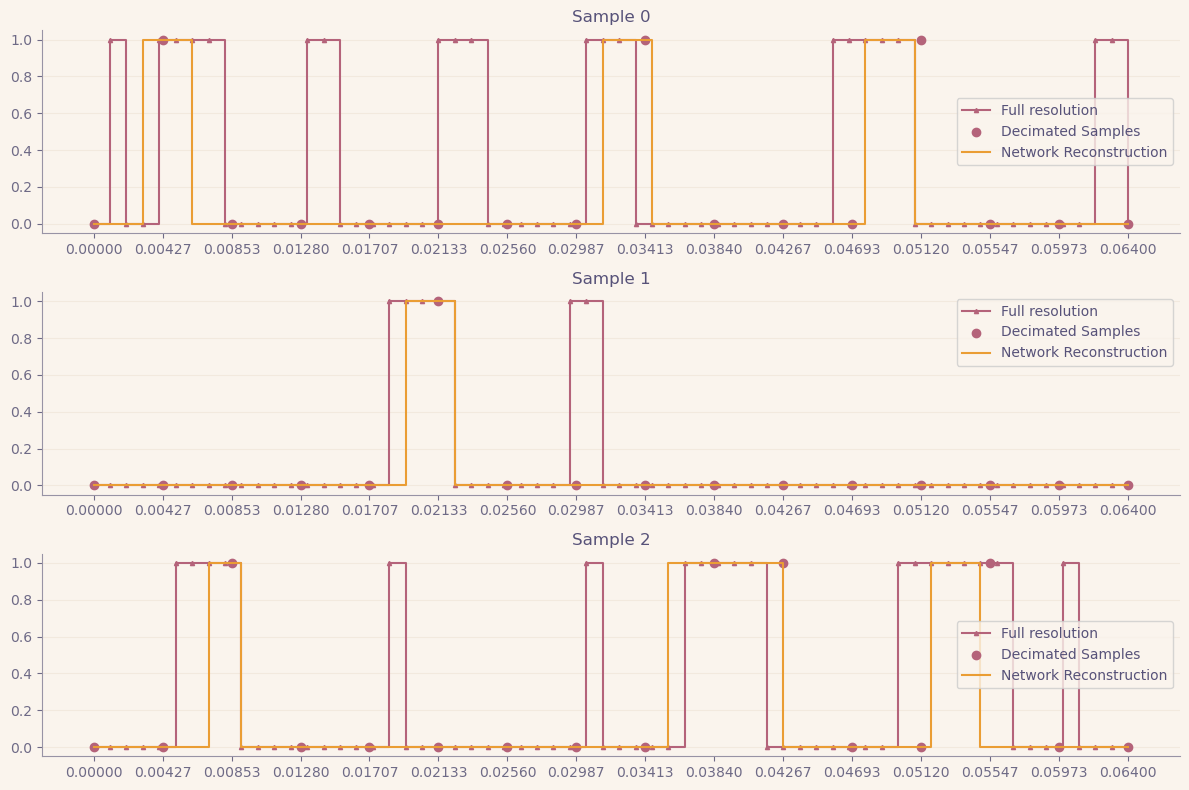

In [62]:
# Take few samples
num_examples = 3

# Plot the results
fig,axs = plt.subplots(3,1,figsize=(12,8))
for i in range(num_examples):
    full_res = batch[i]
    sample = batch_sampled[i]
    reconstruction = res[i]

    print(f"Shape of the three is {full_res.shape}, {sample.shape}, {reconstruction.shape}")
    high_res_x = np.linspace(0,path_length*high_res_delta, len(full_res))

    # Plot full resolution stair plot
    axs[i].plot(np.linspace(0,path_length*high_res_delta, len(full_res)),full_res,drawstyle="steps-post",label="Full resolution", marker="^",markersize=3)

    # Plot Samples
    x_tickies = np.linspace(0,path_length*high_res_delta, len(sample))
    axs[i].scatter(x_tickies,sample,label="Decimated Samples")
    axs[i].set_xticks(x_tickies)

    # Plot Reconstruction
    axs[i].plot(np.linspace(0,path_length*high_res_delta, len(reconstruction)),reconstruction,drawstyle="steps-post",label="Network Reconstruction")

    axs[i].legend()
    axs[i].set_title(f"Sample {i}")
fig.tight_layout()
plt.plot()

# Test Performance on Different Rates

In [ ]:
# Generate surprises
all_possible_lams = np.logspace(0.01,8,100, base=2)
all_possible_lams = np.logspace(0.01,8,100, base=2)

In [ ]:
# Create the surprise dataset
def multimodal_generation(rates_list, path_length, initial_state):
    surprise_tapes = []
    for rates in rates_list:
        Q = np.array([[-rates["lam"],rates["lam"]],[rates["mu"],-rates["mu"]]])# Necessary to fit into TransitionMatrixBD generator
        generator = TransitionMatrixBD(Q, sampling_interval= )
        state_tape = generator.generate_history(initial_state,path_length)
        surprise_tapes.append(state_tape)
    return surprise_tapes

surprise_sts = multimodal_generation(available_surprise, path_length, initial_state)

In [82]:
# Take the pretrained network and show it the surprise dataset
# Create a mapping from the surprise dataset to a calculaation performed on it
avg_exit_rate_mappign = { np.mean(list(dicto.values())) : dicto for dicto in available_surprise}
# Sort based on key 
sorted_surprise = sorted(avg_exit_rate_mappign.items(), key=lambda x: x[0])
print(sorted_surprise)

[(0.16171256574801246, {'lam': 0.125, 'mu': 0.19842513149602492}), (0.21999013123685915, {'lam': 0.125, 'mu': 0.3149802624737183}), (0.2567026969848716, {'lam': 0.19842513149602492, 'mu': 0.3149802624737183}), (0.3125, {'lam': 0.125, 'mu': 0.5}), (0.34921256574801246, {'lam': 0.19842513149602492, 'mu': 0.5}), (0.4074901312368592, {'lam': 0.3149802624737183, 'mu': 0.5}), (0.45935026299204984, {'lam': 0.125, 'mu': 0.7937005259840997}), (0.4960628287400623, {'lam': 0.19842513149602492, 'mu': 0.7937005259840997}), (0.554340394228909, {'lam': 0.3149802624737183, 'mu': 0.7937005259840997}), (0.6468502629920498, {'lam': 0.5, 'mu': 0.7937005259840997}), (0.6924605249474365, {'lam': 0.125, 'mu': 1.259921049894873}), (0.729173090695449, {'lam': 0.19842513149602492, 'mu': 1.259921049894873}), (0.7874506561842957, {'lam': 0.3149802624737183, 'mu': 1.259921049894873}), (0.8799605249474365, {'lam': 0.5, 'mu': 1.259921049894873}), (1.0268107879394863, {'lam': 0.7937005259840997, 'mu': 1.2599210498948

In [89]:
# Once they are sorted we will generate a batch each and feed it to the network
# Then we will check for the loss and plot the results as a function of the surprise

losses = []
for avg_exit_rate, surprise in sorted_surprise:
    sts = []
    for b in range(512):
        Q = np.array([[-surprise["lam"],surprise["lam"]],[surprise["mu"],-surprise["mu"]]])# Necessary to fit into TransitionMatrixBD generator
        generator = TransitionMatrixBD(Q, high_res_delta)
        sts.append(generator.generate_history(initial_state,path_length))
    sts = torch.Tensor(sts).to(torch.float).view(1,-1,64)
    sts_sampled = sts[:,:,::decimanation_factor]
    res = bce_network(sts_sampled)
    losses.append(criterion(res,sts).detach().item())


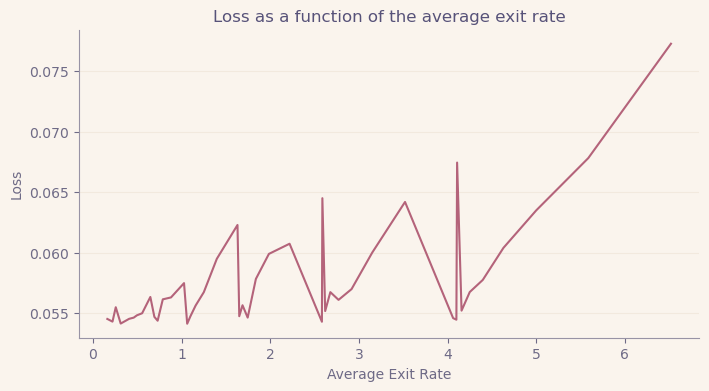

In [90]:
# Plot the losses
fig, axs = plt.subplots(1,1,figsize=(8,4))
axs.plot([x[0] for x in sorted_surprise],losses)
axs.set_xlabel("Average Exit Rate")
axs.set_ylabel("Loss")
axs.set_title("Loss as a function of the average exit rate")
plt.show()

# Quesitons

1. How to prove similarities between using race of exponentials and sampling $P_{\Delta t}$
    - Statistica similarities to prove something analogous to isomorphism ?